# Assignment 4

## Part 1

In [2]:
import torch
print(torch.cuda.is_available()) 
print(torch.version.cuda)     

True
12.1


In [4]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import cv2
import os

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
model.to(device)
print(next(model.parameters()).device)
model.eval()

cuda:0


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

One example frame of video data

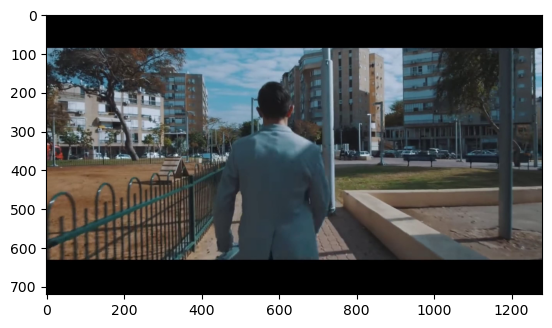

In [6]:
import cv2
import matplotlib.pyplot as plt

# Enable inline plotting if you're in JupyterLab
%matplotlib inline  

# Load the video
video_capture = cv2.VideoCapture("./streetview.mp4")

# Read a frame
ret, frame = video_capture.read()

# Release the video capture
video_capture.release()

# Check if the frame was successfully read
if ret and frame is not None:
    # Convert BGR to RGB for matplotlib
    plt.imshow(frame[:, :, ::-1])
    plt.show()
else:
    print("Error: Could not read frame from video.")

In [10]:
if not os.path.exists('frames'):
    os.makedirs('frames')

In [11]:
# COCO class labels
COCO_CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 
    'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 
    'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 
    'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 
    'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 
    'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 
    'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 
    'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 
    'teddy bear', 'hair drier', 'toothbrush'
]

In [12]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

video_path = 'streetview.mp4'
video_capture = cv2.VideoCapture(video_path)

In [13]:
if not os.path.exists('frames'):
    os.makedirs('frames')

# Extract frames from the video
frame_count = 0
success, frame = video_capture.read()

while success:
    cv2.imwrite(f'frames/frame_{frame_count:04d}.jpg', frame)
    success, frame = video_capture.read()
    frame_count += 1
    
video_capture.release()

In [14]:
def frame_object_detection(frame, model, threshold=0.5):
    image = F.to_tensor(frame).unsqueeze(0)
    
    with torch.no_grad():
        predictions = model(image)[0]

    # Draw bounding boxes for all detected objects
    for box, label, score in zip(predictions['boxes'], predictions['labels'], predictions['scores']):
        if score >= threshold:
            box = box.int().tolist()
            class_name = COCO_CLASSES[label.item()]
            label_text = f'{class_name} {score:.2f}'
            cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
            cv2.putText(frame, label_text, (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return frame

In [15]:
processed_frames = []
for i in range(frame_count):
    frame = cv2.imread(f'frames/frame_{i:04d}.jpg')
    processed_frame = frame_object_detection(frame, model)
    if processed_frame is not None:
        processed_frames.append(processed_frame)

In [16]:
output_path = 'result.mp4'
height, width, _ = processed_frames[0].shape
video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), 20, (width, height))

for frame in processed_frames:
    video_writer.write(frame)

video_writer.release()
cv2.destroyAllWindows()

## Part 2